In [1]:
import os
import numpy as np
import pandas as pd
import math

from textblob import TextBlob as tb
from __future__ import division, unicode_literals

import matplotlib.pyplot as plt
from IPython.display import IFrame, display

pd.options.display.max_columns = None

In [2]:
import sys  

# reload(sys)  
# sys.setdefaultencoding('utf8') # needed for textblob

In [3]:
file1 = "data/articles1.csv"
# filenames = ["data/articles{}.csv".format(n) for n in [1,2,3]]

In [4]:
df = pd.read_csv(file1, encoding='utf-8')
# df['content'] = df.content.str.encode('utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Unnamed: 0     50000 non-null int64
id             50000 non-null int64
title          50000 non-null object
publication    50000 non-null object
author         43694 non-null object
date           50000 non-null object
year           50000 non-null float64
month          50000 non-null float64
url            0 non-null float64
content        50000 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [5]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [6]:
df.publication.value_counts()

Breitbart           23781
CNN                 11488
New York Times       7803
Business Insider     6757
Atlantic              171
Name: publication, dtype: int64

#### Wow that feels like a strange skew towards Breitbart (perhaps because they are prolific). Will have to keep this in mind whenever considering relative frequencies

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')
# .apply(lambda x: )

def preprocess(doc):
    doc = doc.lower().replace('[^\w\s]','').replace(u'•','')
    doc = " ".join([w for w in word_tokenize(doc) if not w in stop_words])
    return doc

def df_to_stringlist(df):
    docs = df['content'].tolist()
    return [preprocess(doc) for doc in docs]

In [8]:
# orlando shooting happened on 6/12/2016
df['day'] = df.date.map(lambda d: int(d.split('-')[2]))
other_events_df = df[(df.year == 2016) & (df.month == 6) & (df.day >= 12)].head(4)
other_events = df_to_stringlist(other_events_df)

In [9]:
# ids 20547 and 20550 are for orlando
orlando_stories = df_to_stringlist(df[df.id.isin([20547, 20550])])

In [10]:
stories = orlando_stories + other_events

In [11]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [21]:
def get_top_words(bloblist, blobcorpus, ntop_words=3):
    top_words = []
    for i, blob in enumerate(bloblist):
        print("Top words in document {}:".format(i + 1))
        scores = {word: tfidf(word, blob, blobcorpus) for word in blob.words}
        sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        for word, score in sorted_words[:ntop_words]:
            print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))
        
        top_words.append(sorted_words[:ntop_words])
        
    return top_words

In [23]:
bloblist = [tb(doc) for doc in stories]
corpus = [tb(doc) for doc in stories + df_to_stringlist(df.sample(20))]
top_words = get_top_words(bloblist[:3], corpus,10)

Top words in document 1:
	Word: mateen, TF-IDF: 0.01781
	Word: shooting, TF-IDF: 0.01781
	Word: islamic, TF-IDF: 0.01394
	Word: orlando, TF-IDF: 0.01394
	Word: mr, TF-IDF: 0.01313
	Word: enforcement, TF-IDF: 0.01187
	Word: assault, TF-IDF: 0.01141
	Word: dead, TF-IDF: 0.01141
	Word: law, TF-IDF: 0.00832
	Word: relatives, TF-IDF: 0.00813
Top words in document 2:
	Word: mateen, TF-IDF: 0.05606
	Word: mr, TF-IDF: 0.02737
	Word: gunman, TF-IDF: 0.02672
	Word: islamic, TF-IDF: 0.01717
	Word: killed, TF-IDF: 0.01717
	Word: attack, TF-IDF: 0.01538
	Word: shooting, TF-IDF: 0.01462
	Word: orlando, TF-IDF: 0.01288
	Word: police, TF-IDF: 0.01196
	Word: explosives, TF-IDF: 0.01125
Top words in document 3:
	Word: mcdonnell, TF-IDF: 0.04664
	Word: justice, TF-IDF: 0.04443
	Word: court, TF-IDF: 0.03403
	Word: corruption, TF-IDF: 0.0272
	Word: mr, TF-IDF: 0.02606
	Word: supreme, TF-IDF: 0.02332
	Word: roberts, TF-IDF: 0.01636
	Word: chief, TF-IDF: 0.01555
	Word: dreeben, TF-IDF: 0.01555
	Word: justice

In [42]:
words1, scores1 = [list(x) for x in zip(*top_words[0])]
words2, scores2 = [list(x) for x in zip(*top_words[2])]

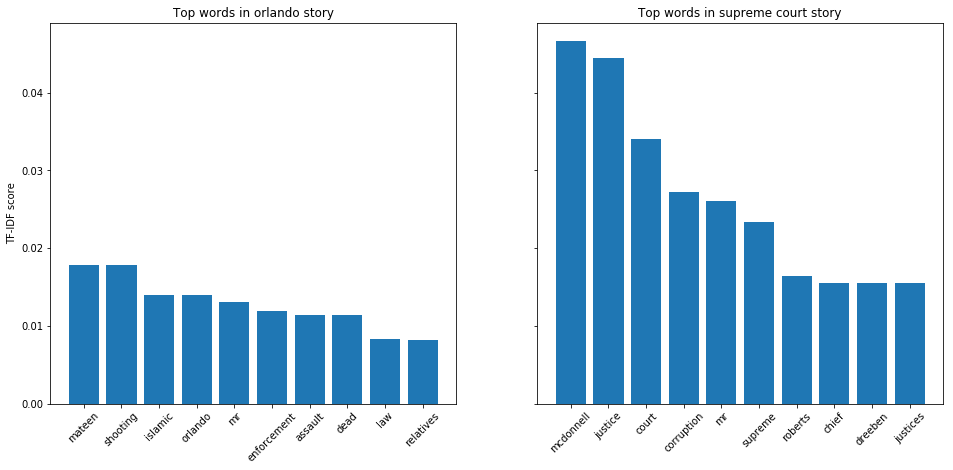

In [57]:
x = range(len(scores))

fig, axarr = plt.subplots(1,2,sharey='row', figsize=(16,7))

ax1 = axarr[0]
ax2 = axarr[1]

ax1.set_title('Top words in orlando story')
ax1.bar(x, scores1)
ax1.set_ylabel('TF-IDF score')
plt.sca(ax1)
plt.xticks(x, words1, rotation=45)

ax2.set_title('Top words in supreme court story')
ax2.bar(x, scores2)
plt.sca(ax2)
plt.xticks(x, words2, rotation=45)

plt.savefig('compare_orlando_tfidf_scores.png')
plt.show()